In [1]:
# code here copied from the Udacity course material

import numpy as np
import cv2
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

from mpl_toolkits.mplot3d import Axes3D
from functools import partial

import dill as pickle

from tqdm import tqdm
import asyncio

from utils import *
from features import *
from boxes import *
from images import *
from detection import *
from search import *

# Import everything needed to edit/save/watch video clips
from moviepy.editor import ImageSequenceClip, VideoFileClip
from IPython.display import HTML

%matplotlib inline   

In [2]:
%load_ext autoreload
%autoreload 2

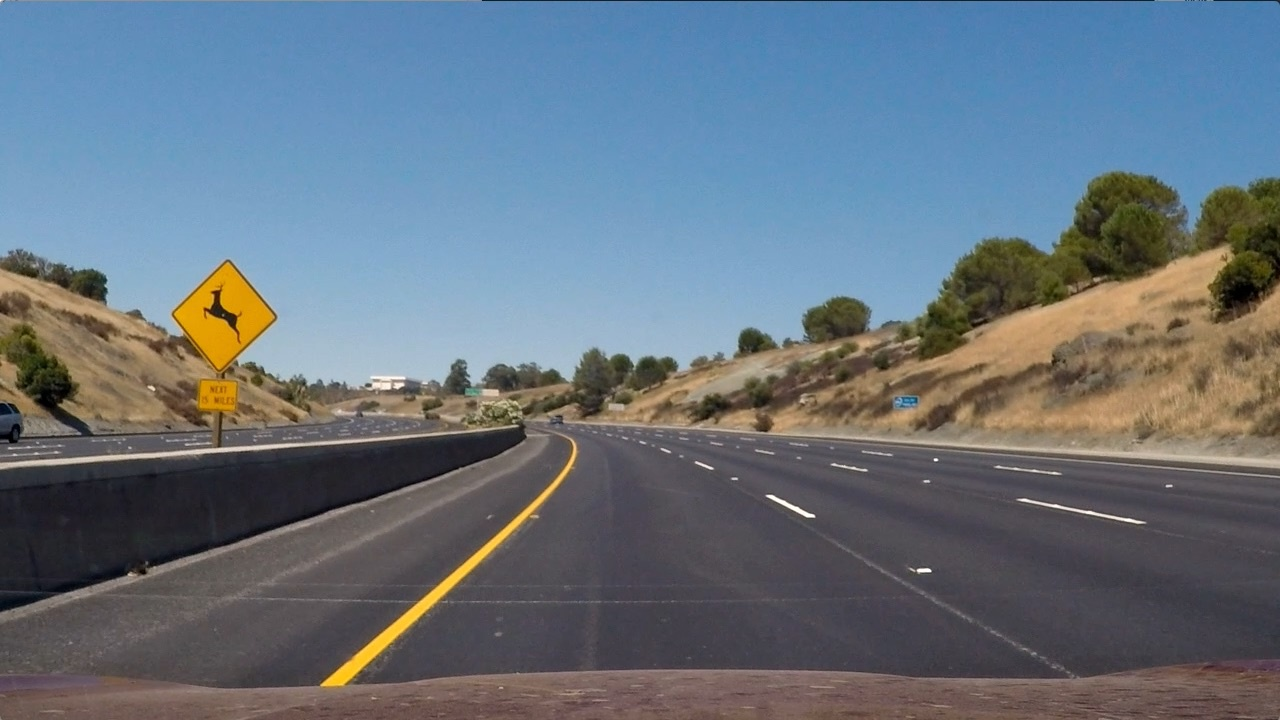

In [3]:
timages, tfiles = load_test_images()
arr2img(cv2.cvtColor(timages[0], cv2.COLOR_BGR2RGB))
#arr2img(images[0][1])
#plt.imshow(images[0][1])

100%|█████████▉| 1260/1261 [00:08<00:00, 149.93it/s]


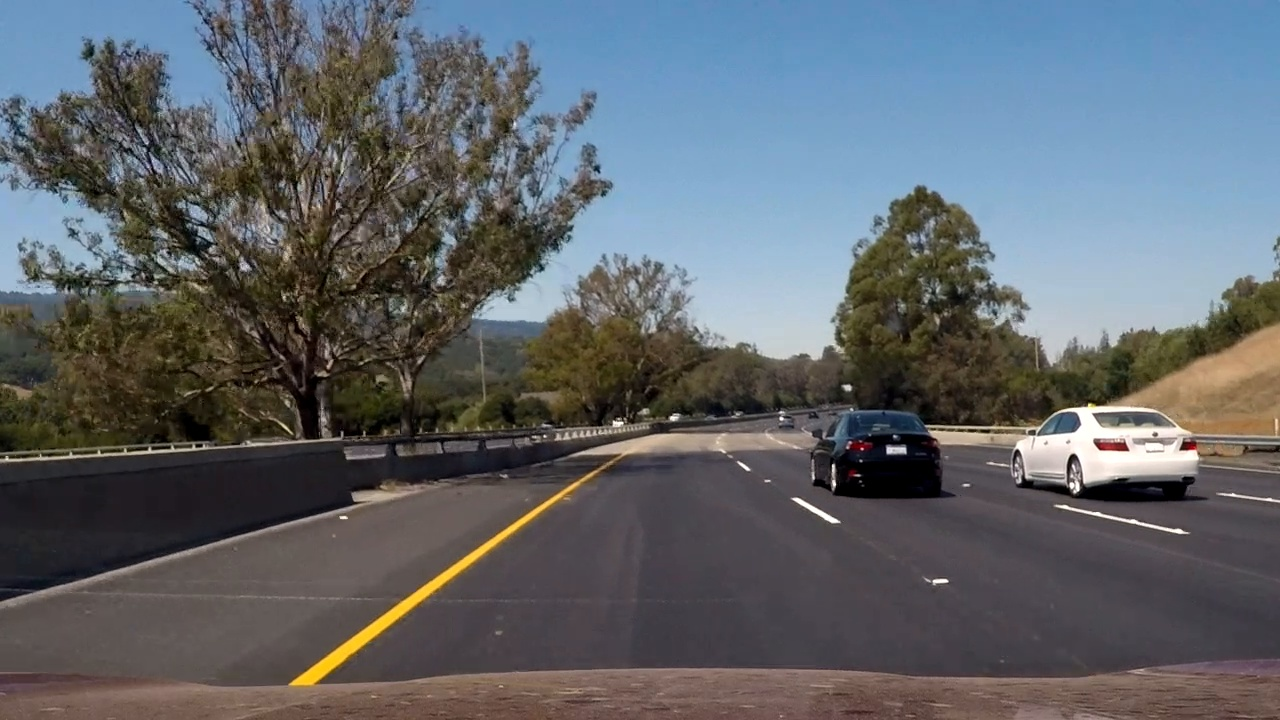

In [4]:
vimages, vframes = load_test_video()
pimages, pframes = load_test_video(file_name='project_video.mp4')
arr2img(cv2.cvtColor(vimages[5], cv2.COLOR_BGR2RGB))

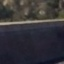

In [5]:
images, files = load_images()
arr2img(cv2.cvtColor(images[0],cv2.COLOR_BGR2RGB))

In [6]:
car_images, not_car_images = load_car_not_car_images()
len(car_images),len(not_car_images)

var/non-vehicles/Extras (5068, 64, 64, 3) 5068
var/non-vehicles/GTI (3900, 64, 64, 3) 3900
var/vehicles/GTI_Far (834, 64, 64, 3) 834
var/vehicles/GTI_Left (909, 64, 64, 3) 909
var/vehicles/GTI_MiddleClose (419, 64, 64, 3) 419
var/vehicles/GTI_Right (664, 64, 64, 3) 664
var/vehicles/KITTI_extracted (5966, 64, 64, 3) 5966


(8792, 8968)

Hog Classify
===

In [7]:
# sample_size = 10000
# cars = car_images[0:sample_size]
# notcars = not_car_images[0:sample_size]

cars = car_images
notcars = not_car_images

colorspace = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 32
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
# also appended a color histogram into the features
car_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
#X_scaler = StandardScaler(with_mean=True, with_std=True).fit(X)
X_scaler = RobustScaler().fit(X)
# X_scaler = MinMaxScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',hog_channel,'hog channel',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

100%|██████████| 8968/8968 [00:15<00:00, 570.29it/s]


31.4 Seconds to extract HOG features...
Using: ALL hog channel 32 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 3456


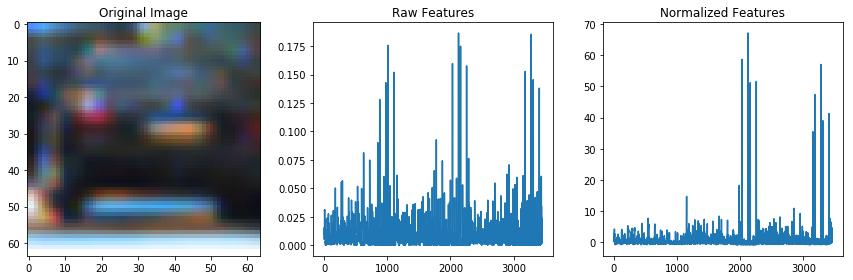

In [8]:
car_ind = np.random.randint(0, len(car_images))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(car_images[car_ind], cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

In [9]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

5.51 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9901
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.]
0.00199 Seconds to predict 10 labels with SVC


In [10]:
wb = WindowBoxes(height=car_images[0].shape[0], width=car_images[0].shape[1])
total=0
for size, windows in wb.window_boxes_dict.items():
    count=len(windows)
    total = total + count
    print("{} count {}".format(size, count))

print("total", total)

small count 240
smallish count 324
medium count 308
large count 65
total 937


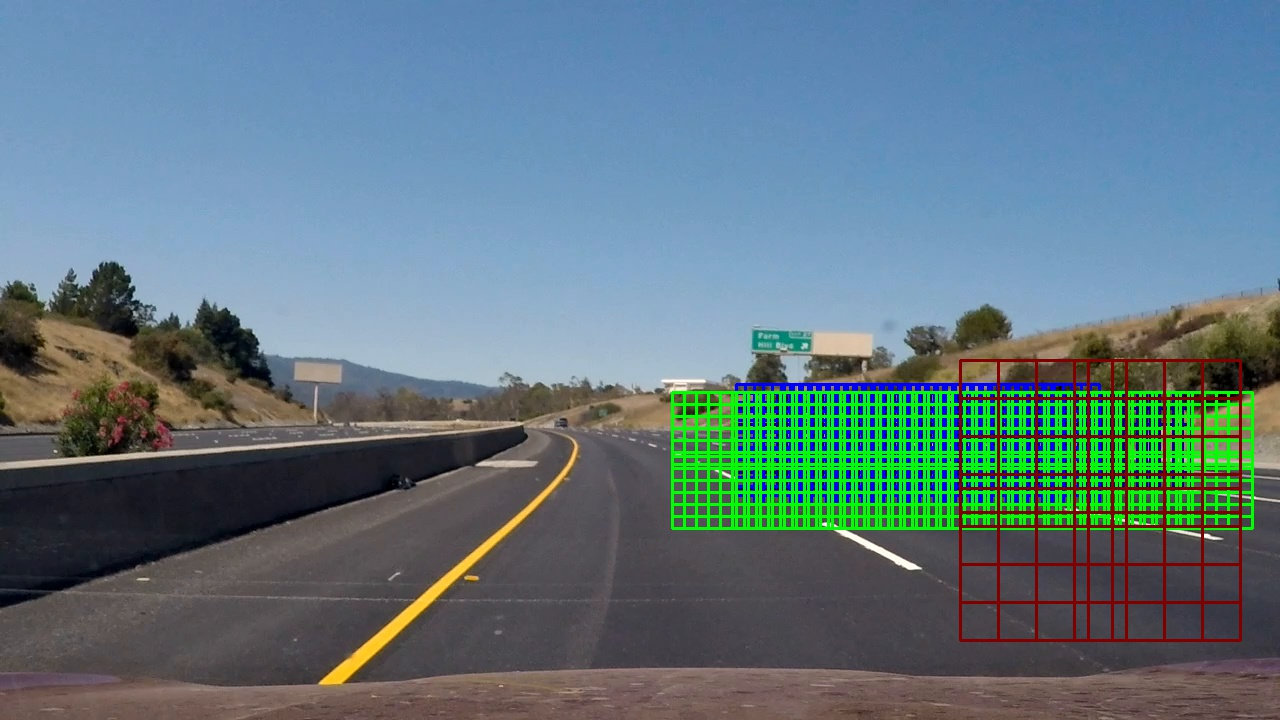

In [11]:
from boxes import WindowBoxes
images, _ = load_test_images()

@interact
def window_test(images=fixed(pimages), i:(0,len(pimages)-1)=0, 
                all_shapes=True,
                shape:wb.shape_keys="small"):    
    image=cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
    height = image.shape[0]
    width = image.shape[1]
    wb = WindowBoxes(height, width)
    box_color=wb.box_colour_dict

    window_dict = wb.build_window_boxes(height, width, all_shapes, shape) 
    window_img=np.copy(image)
    for size, windows in window_dict.items():
        window_img = draw_boxes(window_img, windows, color=box_color[size], thick=2)   
    
    return arr2img(window_img)

In [12]:
# initialise an object to contain common parameters
color_space = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 32  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
hist_range = (0,256)
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

    
search_params = SearchParams(color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size,
                  hist_bins, hist_range, spatial_feat, hist_feat, hog_feat, svc, X_scaler)
print(search_params)

SearchParams(color_space='YCrCb', orient=32, pix_per_cell=16, cell_per_block=2, hog_channel='ALL', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), spatial_feat=False, hist_feat=False, hog_feat=True, clf=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), X_scaler=RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True))


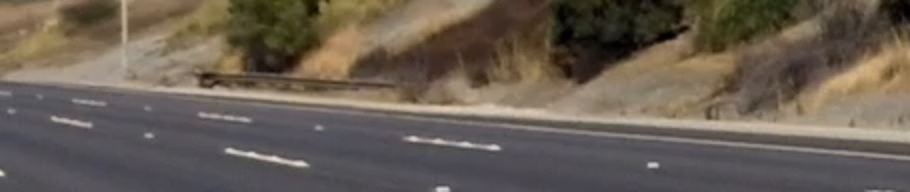

In [13]:
@interact
def camera_window_box_test(images=fixed(pimages), i:(0,len(pimages)-1)=0, shape:wb.shape_keys="small"):
    camera_image=CameraImage(images[i])
    window_boxes=WindowBoxes(camera_image.height, camera_image.width)               

    img=CameraImage.slice_bounding_box_shape_resize_64x64(camera_image.image, window_boxes, shape)
    #print(window_boxes.bounding_box(shape), window_boxes.resize_64x64_ratio(shape), img.shape)
    return arr2img(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

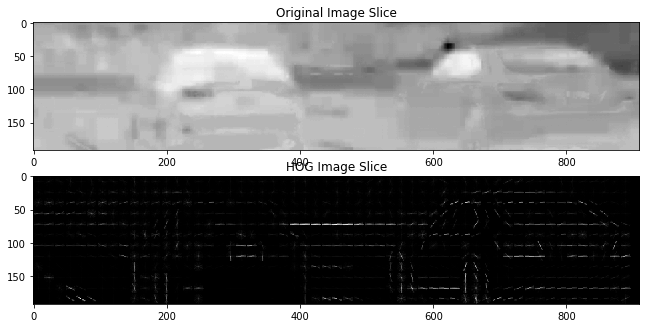

In [14]:
@interact
def hog_slice_test(images=fixed(vimages), i:(0,len(vimages)-1)=0,
                   shape:wb.shape_keys="small"):
    camera_image = CameraImage(images[i])
    window_boxes = WindowBoxes(camera_image.height, camera_image.width)
    image_slice = ImageSlice(camera_image, window_boxes, search_params, shape)
    image_windows = [wbs for wbs in image_slice.window_generator()]
    image = image_slice.image

    hog_image = image_slice.hog_image(1)
#     print(window_boxes.bounding_box(shape), window_boxes.resize_64x64_ratio(shape), image.shape)
  
    hog_features_list = image_slice.hog_features_list
#     print(len(hog_features_list))
#     print("hog_features_list[0].values.shape=",hog_features_list[0].values.shape)
#     print(image_slice.image.shape,hog_image.shape)
    #print(window_boxes.windows(shape))
#     print(image_windows)

#     for w in image_windows:
#         print("windows: %r slice_window %r hog: %r" % (w.bbox, w.bbox_slice,
#                                                        image_slice.window_hog_features(w.bbox_slice)))
    fig = plt.figure(figsize=(20,8))
    plt.subplot(311)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)[:,:,2], cmap='gray')
    plt.title('Original Image Slice')
    plt.subplot(312)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Image Slice')
#     plt.subplot(313)
#     plt.imshow(hog_image, cmap='gray')
#     plt.title('RHS Slice')
#     plt.imshow(cv2.cvtColor(image_slice.slice_window(image_windows[-1:][0].bbox_slice), cv2.COLOR_YCrCb2RGB))         

2 cars found


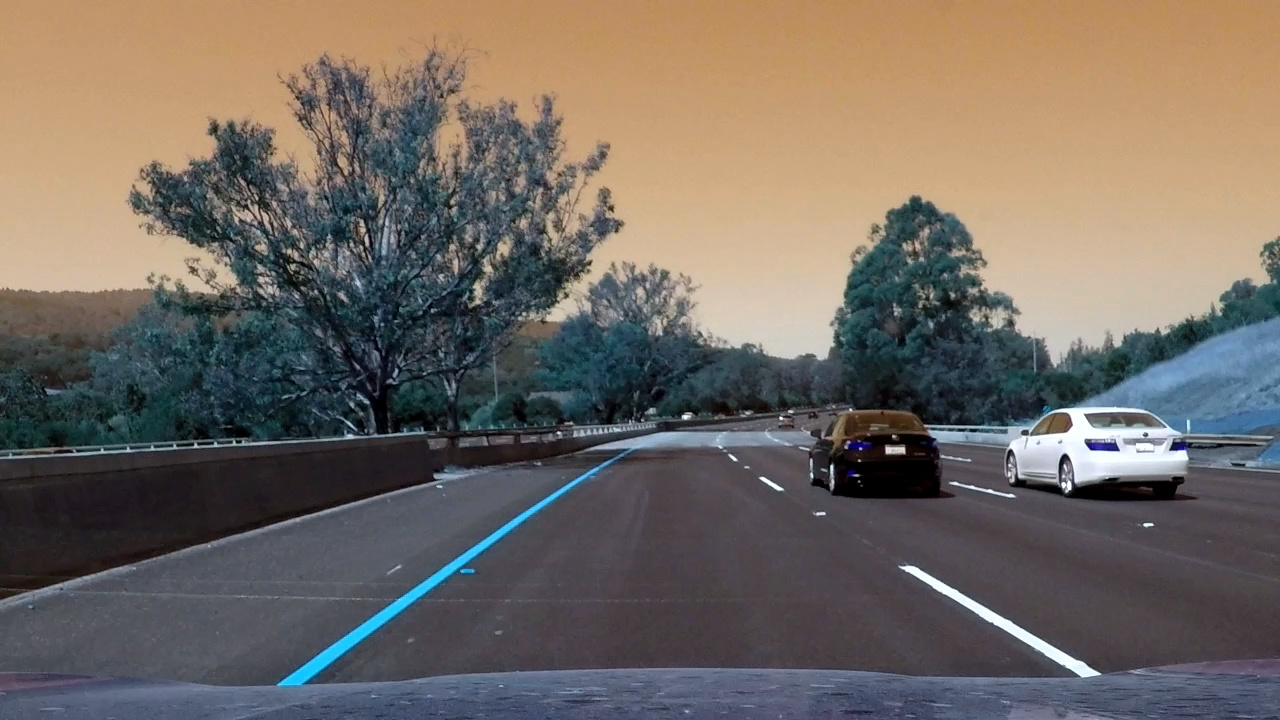

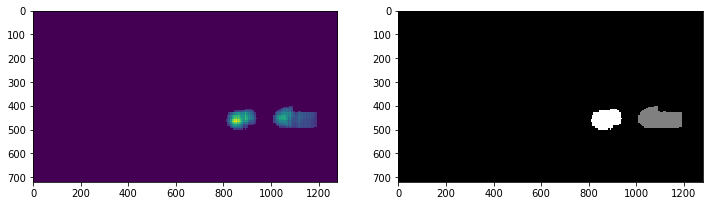

In [15]:
loop = asyncio.new_event_loop()
asyncio.set_event_loop(loop)

@interact
def hot_windows_test(images=fixed(vimages), i:(0,len(vimages)-1)=0):

    vehicle_detection = VehicleDetection(search_params,images[i].shape[0], images[i].shape[1], loop)
    vehicle_detection.image = images[i]
    #return arr2img(vehicle_detection.result)
    
    fig = plt.figure(figsize=(12,4))
    plt.subplot(122)
    labels = vehicle_detection.labels
    print(labels[1], 'cars found')
    plt.imshow(labels[0][0], cmap='gray')
    plt.subplot(121)
    heatmap = vehicle_detection.heatmap
    plt.imshow(heatmap)
    #sns.heatmap(heatmap)
    #sns.xticklabels = False
    plt.show
    
    #plt.imshow(heatmap)
    
#     return arr2img(vehicle_detection.result_decorated)
#     return arr2img(vehicle_detection.heatmap_decorated)
#    camera_image=CameraImage(images[i])
#    window_boxes=WindowBoxes(camera_image.height, camera_image.width)
#     image=camera_image.image_bottom
#     print(camera_image.image_bottom.shape)
#     print(camera_image.hog_features(search_params))
#     features,hog_image = camera_image.hog_channel_features(image[:,:,2],search_params,vis=True,feature_vec=True)
#     print(features.shape)
#     return arr2img(hog_image)
    #hot_windows=hot_windows_search(camera_image, window_boxes, search_params)
    #window_img = draw_boxes(camera_image.rgb, hot_windows, color=(0, 0, 255), thick=2)                    

#     image=CameraImage.slice_bounding_box_shape_resize_64x64(camera_image, window_boxes, shape)
#     features,hog_image = camera_image.hog_channel_features(image[:,:,2],search_params,vis=True,feature_vec=True)
#     print(window_boxes.bounding_box(shape), window_boxes.resize_64x64_ratio(shape), img.shape)
    return arr2img(vehicle_detection.image)


In [19]:
loop = asyncio.new_event_loop()
asyncio.set_event_loop(loop)

rimages=[]
def do_project_video(file_name, output_name):
    height, width = (720,1280)
    
    count=0
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    detection = VehicleDetection(search_params, height, width, loop)
    
    def process_image(image):
        nonlocal count
        
        # process the lane image
        detection.image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        result = cv2.cvtColor(detection.result, cv2.COLOR_BGR2RGB)

        result = cv2.putText(result,'%4d' % count,(5,700), font, 1,(255,255,255),2,cv2.LINE_AA)
        count +=1
        
        rimages.append(result)
        return result

    clip1 = VideoFileClip(file_name)
    lane_clip = clip1.fl_image(process_image) 
    %time lane_clip.write_videofile(output_name, audio=False)
    
    return lane_clip

detection_clip = do_project_video("test_video.mp4","test_video_detection.mp4")
detection_clip = do_project_video("project_video.mp4","project_video_detection.mp4")

[MoviePy] >>>> Building video test_video_detection.mp4
[MoviePy] Writing video test_video_detection.mp4


 97%|█████████▋| 38/39 [00:23<00:00,  1.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_detection.mp4 

CPU times: user 23.4 s, sys: 876 ms, total: 24.3 s
Wall time: 24.7 s
[MoviePy] >>>> Building video project_video_detection.mp4
[MoviePy] Writing video project_video_detection.mp4


100%|█████████▉| 1260/1261 [13:36<00:00,  1.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_detection.mp4 

CPU times: user 13min 10s, sys: 33 s, total: 13min 43s
Wall time: 13min 36s


In [20]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format("test_video_detection.mp4"))